In [1]:
# 1. Imports & Paths
import importlib.util
import os, sys, re, pandas as pd
sys.path.append(os.path.join(os.pardir, "utils"))

DATA_DIR = os.path.join(os.pardir, "data")
resume_path = os.path.join(DATA_DIR, "resumes_cleaned.csv")
jobs_path   = os.path.join(DATA_DIR, "jobs_cleaned.csv")

In [2]:
# 2. Load Data
resume_df = pd.read_csv(resume_path)
job_posts_df = pd.read_csv(jobs_path)

In [3]:
%load_ext autoreload
%autoreload 2
from utils import *


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


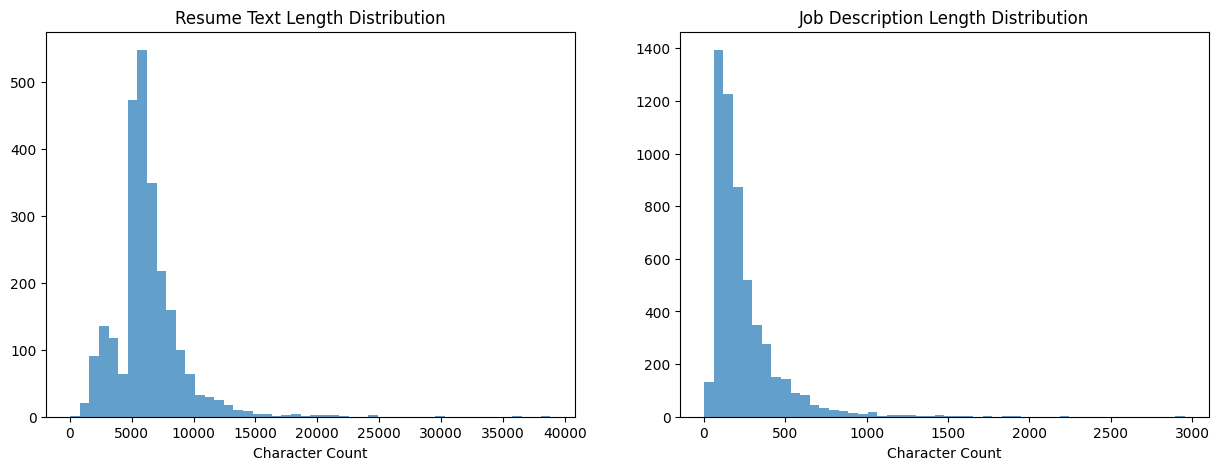

In [4]:
resume_lengths = resume_df['Resume_str'].str.len()
job_lengths = job_posts_df['JobDescription'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(resume_lengths, bins=50, alpha=0.7)
ax1.set_title('Resume Text Length Distribution')
ax1.set_xlabel('Character Count')

ax2.hist(job_lengths, bins=50, alpha=0.7)
ax2.set_title('Job Description Length Distribution')
ax2.set_xlabel('Character Count')
plt.show()

In [27]:
# Custom low-value / too-general words to ignore
custom_stopwords = {
    "state", "city", "company", "name", "university", "office",
    "llc", "cjsc", "armenia",
    "skills", "experience", "team", "work", "information",
    "professional", "current", "high", "including",
    "responsible", "managed", "maintained", "developed", "ensure",
    "quality", "customers", "customer", "service", "support",
    "working", "activities", "projects.", "motivated", "highly",
    "qualified", "looking", "seeking", "candidate", "incumbent",
    "position", "provide", "well",
    "business", "management", "management,", "project", "development",
    "training", "sales", "financial", "marketing", "design", "product",
    "system", "process", "staff", "manager", "new",
    "education", "microsoft", "client", "clients", "provided", "services",
    "program", "school", "college", "daily", "monthly", "time", "within",
    "systems", "various", "account", "accounts", "accounting",
    "reports", "summary", "performance", "maintain", "created",
    "knowledge", "worked", "general", "strong", "public", "projects",
    "technology", "employee", "health", "food", "operations",
    "senior", "experienced", "applications", "international",
    "supervision", "person", "part", "based", "also", "manage",
    "related", "direct", "different", "company's", "company.",
    "manager.", "team.", "products", "students", "january",

    # NEW — All months (lowercase)
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december", 
    "using","communication","assisted","years","department","prepared","needs",
"excellent","cash","student","member","multiple","sales,","2014",
"he/","candidates","role","join","fulfill","successful",
"applications.","development.","responsibility","perform","providing",
"armenia.","armenian","yerevan", "assistant", "lead", "key", "2013", "programs", "assist",
"design,", "products.", "take", "head", "involved", "center", "long-term","performed","issues","internal","ability","personal","special",
"annual","cost","companys","ensuring","leadership","community","human","employees","control","key","primary", "control", "performed", "issues", "internal", "ability",
"cost", "special", "annual", "personal", 
"ensuring", "companys", "2012", "help", "managing", 
"national"






}


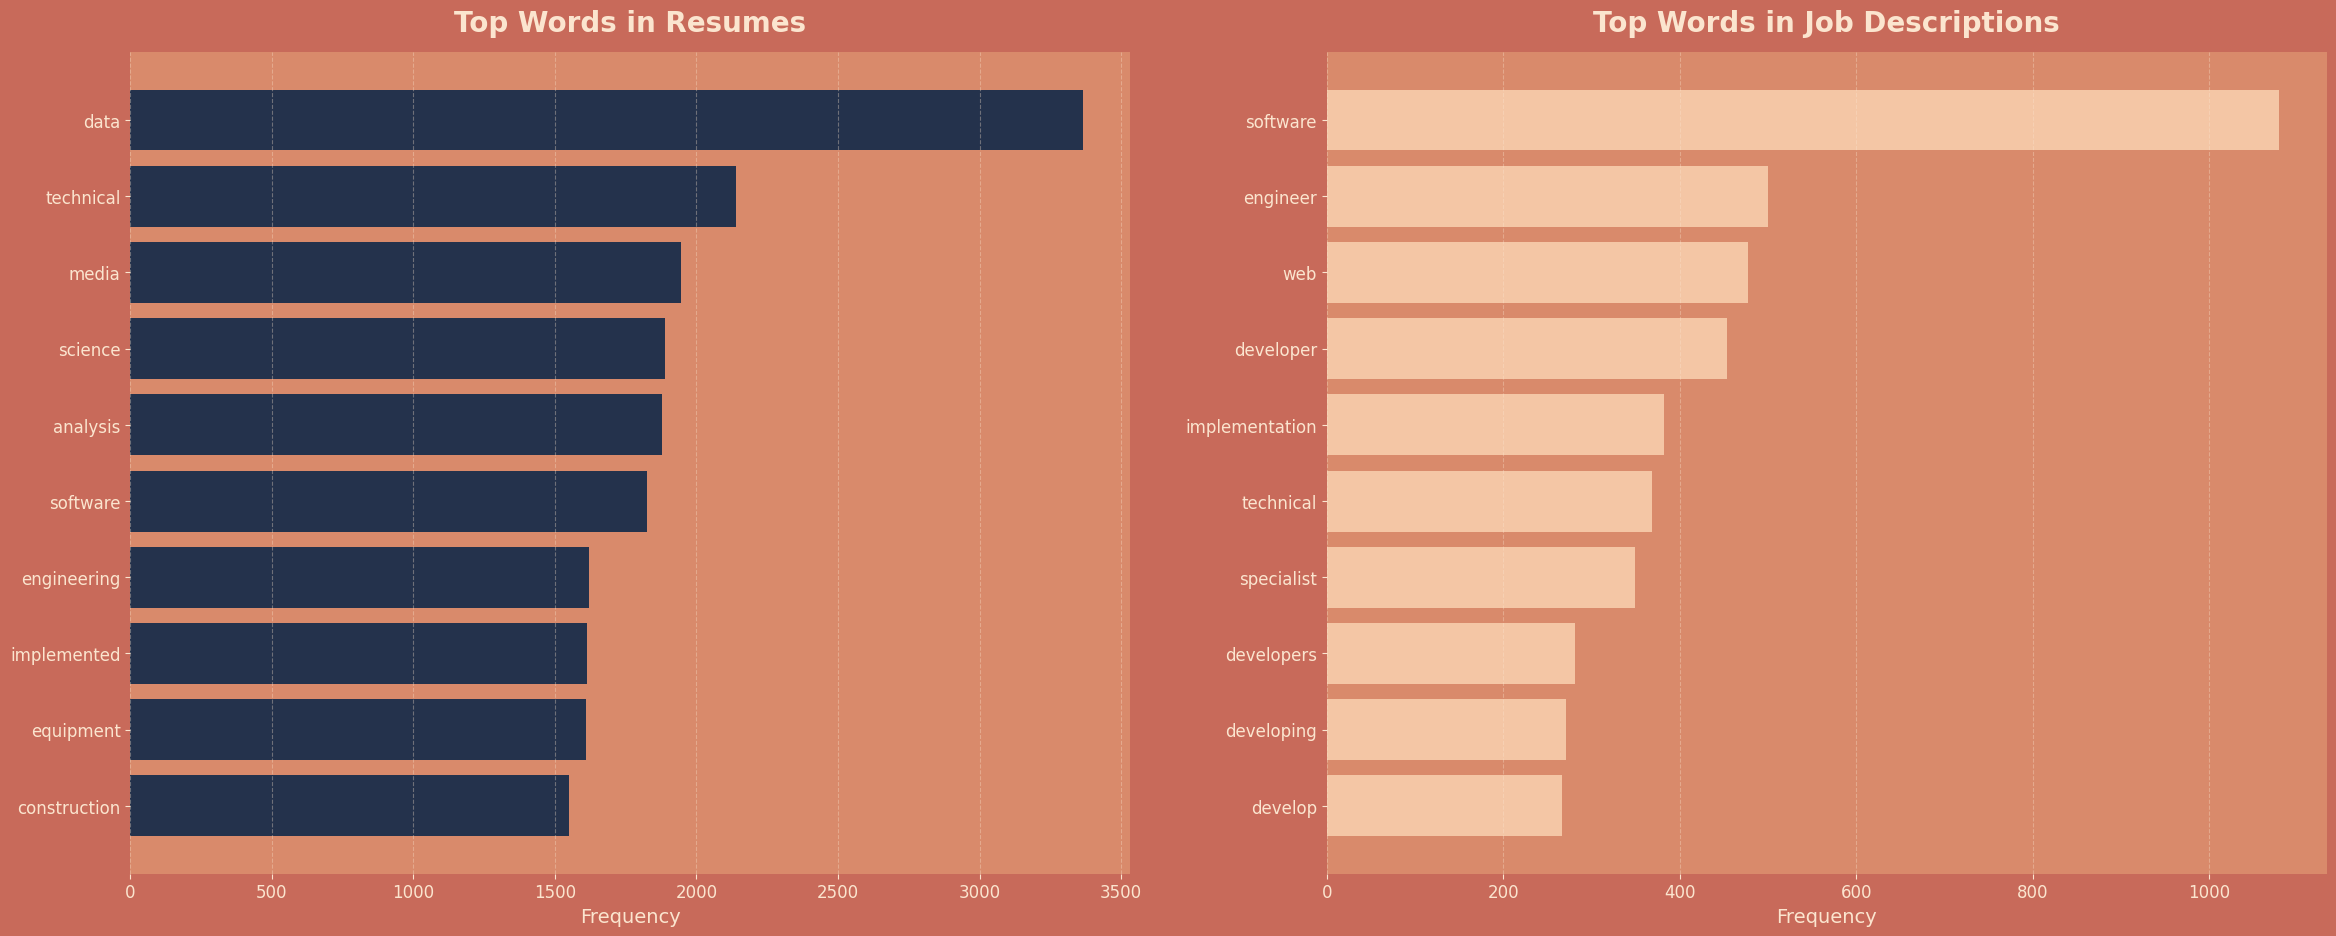

In [39]:
# Get most common words in resumes and job postings
def get_top_words(text_series, n=10):
    all_words = " ".join(text_series).lower().split()

    # Base stopwords
    stop_words = set(stopwords.words("english"))

    # Extend with custom stopwords
    stop_words |= custom_stopwords

    # Filter out stopwords and short words
    filtered_words = [
        word for word in all_words
        if word not in stop_words and len(word) > 2
    ]

    return Counter(filtered_words).most_common(n)

top_resume_words = get_top_words(resume_df["Resume_str"])
top_job_words = get_top_words(job_posts_df["JobDescription"])

# ----------------- AESTHETIC PLOTTING (Cadence theme) -----------------
import matplotlib.pyplot as plt

# Approx colors from your deck
bg_color       = "#C86A5A"  # warm terracotta (slide background)
panel_color    = "#D98A6B"  # slightly lighter panel
text_color     = "#FBE5CF"  # light cream text
resume_bar     = "#24324C"  # navy (like the "03" badge)
job_bar        = "#F4C6A5"  # peach accent (like footer bar)
grid_color     = "#FBE5CF"  # soft cream gridlines

plt.style.use("default")

# Reverse so smallest at top, biggest at bottom (nicer for barh)
res_words, res_counts = zip(*reversed(top_resume_words))
job_words, job_counts = zip(*reversed(top_job_words))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.patch.set_facecolor(bg_color)

for ax in (ax1, ax2):
    ax.set_facecolor(panel_color)
    ax.tick_params(colors=text_color, labelsize=12)
    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)
    ax.title.set_color(text_color)
    # Remove borders for a flat slide look
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Soft gridlines
    ax.grid(axis="x", linestyle="--", linewidth=0.8,
            alpha=0.35, color=grid_color)

# --- Resume plot ---
ax1.barh(res_words, res_counts, color=resume_bar)
ax1.set_title("Top Words in Resumes", fontsize=, pad=15, fontweight="bold")
ax1.set_xlabel("Frequency", fontsize=14)

# --- Job description plot ---
ax2.barh(job_words, job_counts, color=job_bar)
ax2.set_title("Top Words in Job Descriptions", fontsize=20, pad=15, fontweight="bold")
ax2.set_xlabel("Frequency", fontsize=14)

plt.tight_layout(pad=3)
plt.show()


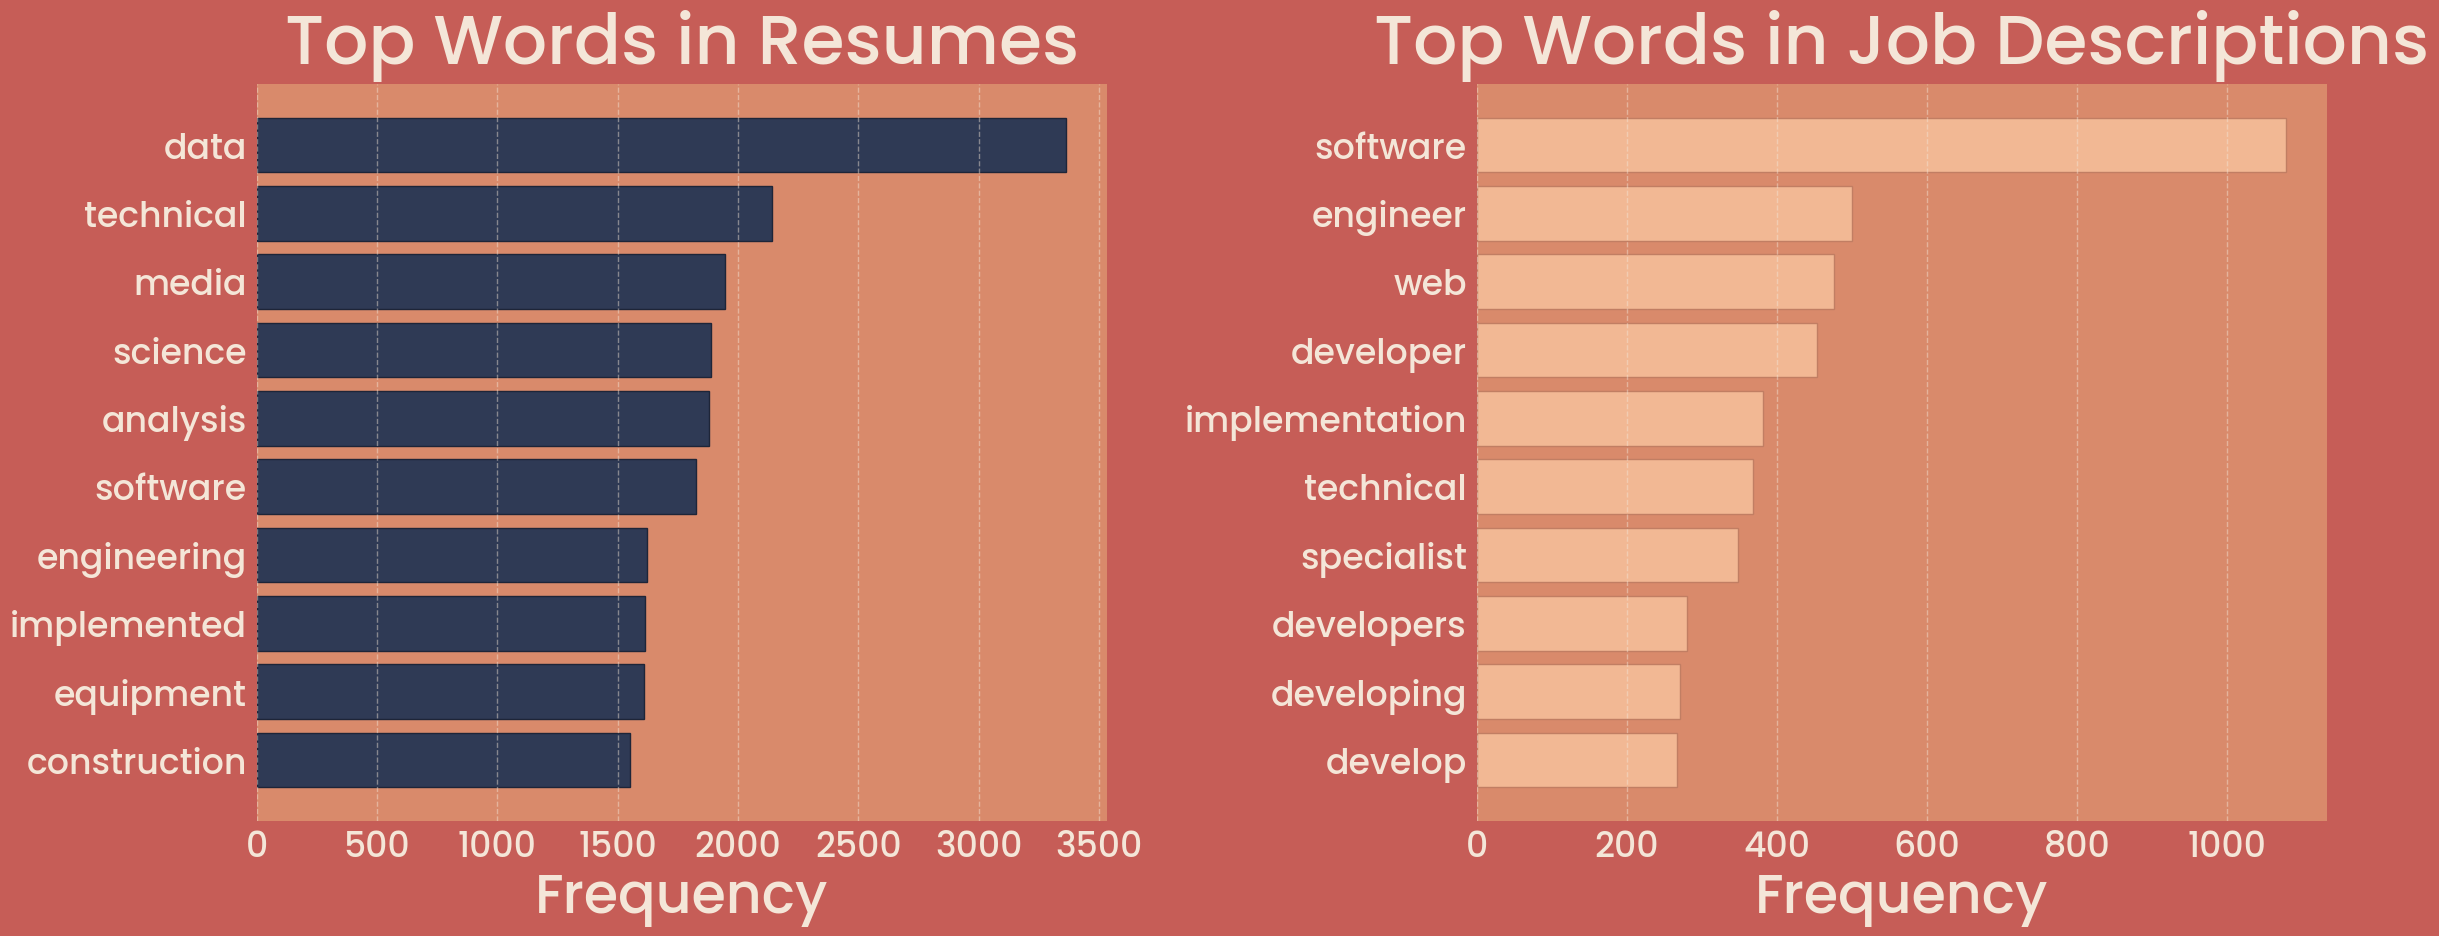

In [47]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Path to your uploaded font
font_path = "Poppins-Medium.ttf"

# Register font
fm.fontManager.addfont(font_path)

# Set global font family + weight
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.weight"] = "medium"



# Colors themed to your deck
bg_color       = "#c65d57"   # terracotta
panel_color    = "#D98A6B"   # lighter terracotta panel
text_color     = "#F4E6D8"   # warmer cream
resume_bar     = "#2F3A55"   # soft navy
job_bar        = "#F2B894"   # peach accent
grid_color     = "#F4E6D890" # semi-transparent cream gridlines

# Reverse for nicer barh order
res_words, res_counts = zip(*reversed(top_resume_words))
job_words, job_counts = zip(*reversed(top_job_words))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.patch.set_facecolor(bg_color)

for ax in (ax1, ax2):
    ax.set_facecolor(panel_color)

    # Tick styling
    ax.tick_params(colors=text_color, labelsize=25, width=0)

    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)
    ax.title.set_color(text_color)

    # Clean frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(axis="x",
            linestyle="--",
            linewidth=1.0,
            alpha=0.45,
            color=grid_color)

# Resume plot
ax1.barh(res_words, res_counts,
         color=resume_bar,
         edgecolor="#1E2538")

ax1.set_title("Top Words in Resumes",
              fontsize=50, pad=15, fontweight="semibold")
ax1.set_xlabel("Frequency", fontsize=40)

# Job Post plot
ax2.barh(job_words, job_counts,
         color=job_bar,
         edgecolor="#C17E63")

ax2.set_title("Top Words in Job Descriptions",
              fontsize=50, pad=15, fontweight="semibold")
ax2.set_xlabel("Frequency", fontsize=40)

plt.tight_layout(pad=3)
plt.show()


In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(top_resume_words, top_job_words):

    # Extract words & counts
    res_words, res_counts = zip(*top_resume_words)
    job_words, job_counts = zip(*top_job_words)

    # Nice color palettes
    resume_color = "#5A6ACF"
    job_color = "#2EC4B6"

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    fig.patch.set_facecolor("white")

    # --- LEFT: Resume ---
    ax1.barh(res_words, res_counts, color=resume_color, edgecolor="none")
    ax1.set_title("Top Words in Resumes", fontsize=20, pad=20, fontweight="bold")
    ax1.grid(axis="x", linestyle="--", alpha=0.3)
    ax1.set_xlabel("Frequency", fontsize=14)
    ax1.tick_params(axis='y', labelsize=12)

    # Remove frame
    for spine in ax1.spines.values():
        spine.set_visible(False)

    # --- RIGHT: Job Descriptions ---
    ax2.barh(job_words, job_counts, color=job_color, edgecolor="none")
    ax2.set_title("Top Words in Job Descriptions", fontsize=20, pad=20, fontweight="bold")
    ax2.grid(axis="x", linestyle="--", alpha=0.3)
    ax2.set_xlabel("Frequency", fontsize=14)
    ax2.tick_params(axis='y', labelsize=12)

    for spine in ax2.spines.values():
        spine.set_visible(False)

    plt.tight_layout(pad=3)
    plt.show()


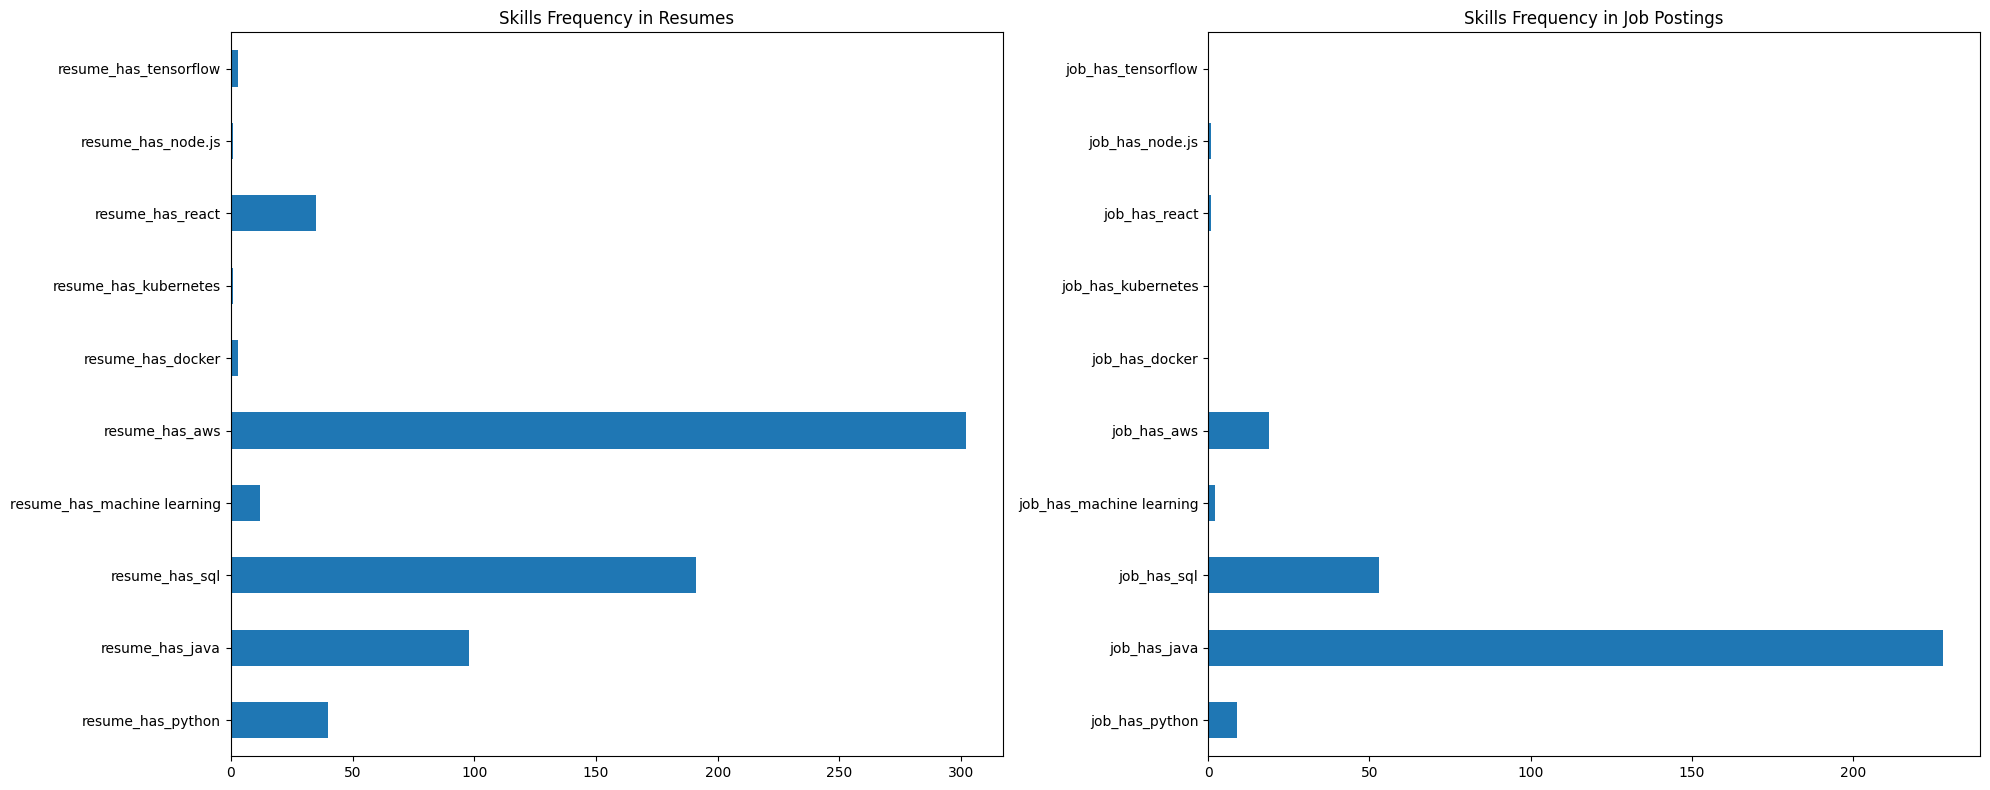

In [6]:
# Common skills extraction (simplified)
# Add/update list with keywords we are interested in
skills_keywords = ['python', 'java', 'sql', 'machine learning', 'aws',
                   'docker', 'kubernetes', 'react', 'node.js', 'tensorflow']

def count_skills(text, skills_list):
    text_lower = text.lower()
    return sum(1 for skill in skills_list if skill in text_lower)

# Count skills in resumes and job postings
for skill in skills_keywords:
    resume_df[f'resume_has_{skill}'] = resume_df['Resume_str'].str.lower().str.contains(skill)
    job_posts_df[f'job_has_{skill}'] = job_posts_df['JobDescription'].str.lower().str.contains(skill)

# Plot skills frequency
resume_skills_count = resume_df[[f'resume_has_{skill}' for skill in skills_keywords]].sum()
job_skills_count = job_posts_df[[f'job_has_{skill}' for skill in skills_keywords]].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
resume_skills_count.plot(kind='barh', ax=ax1)
ax1.set_title('Skills Frequency in Resumes')
job_skills_count.plot(kind='barh', ax=ax2)
ax2.set_title('Skills Frequency in Job Postings')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['long', 'term'] not in stop_words.
  warnings.warn(


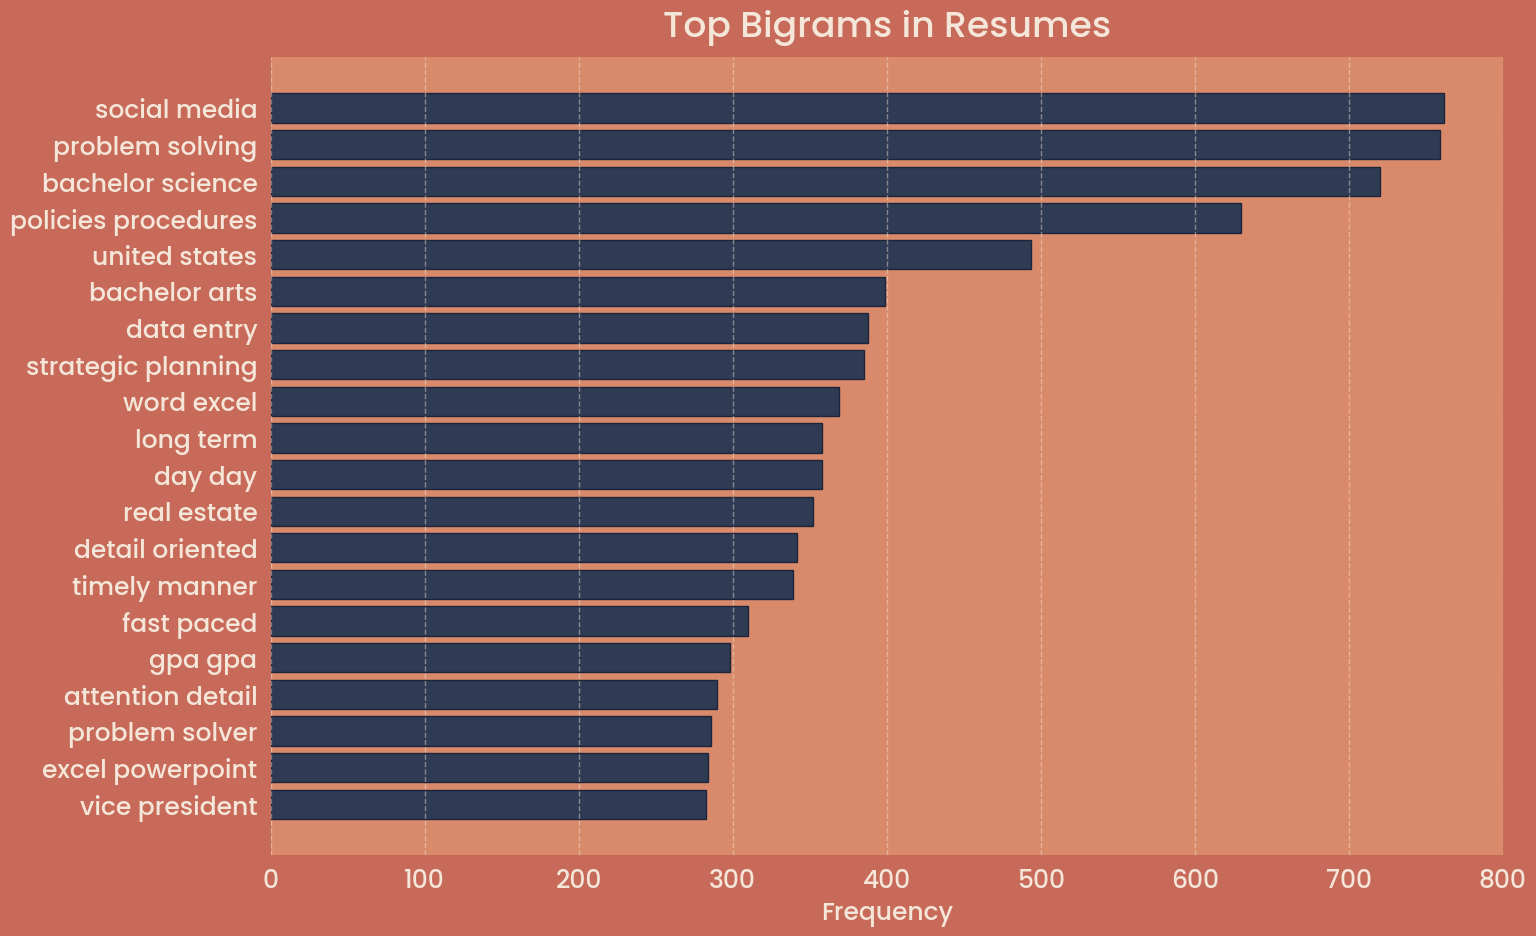

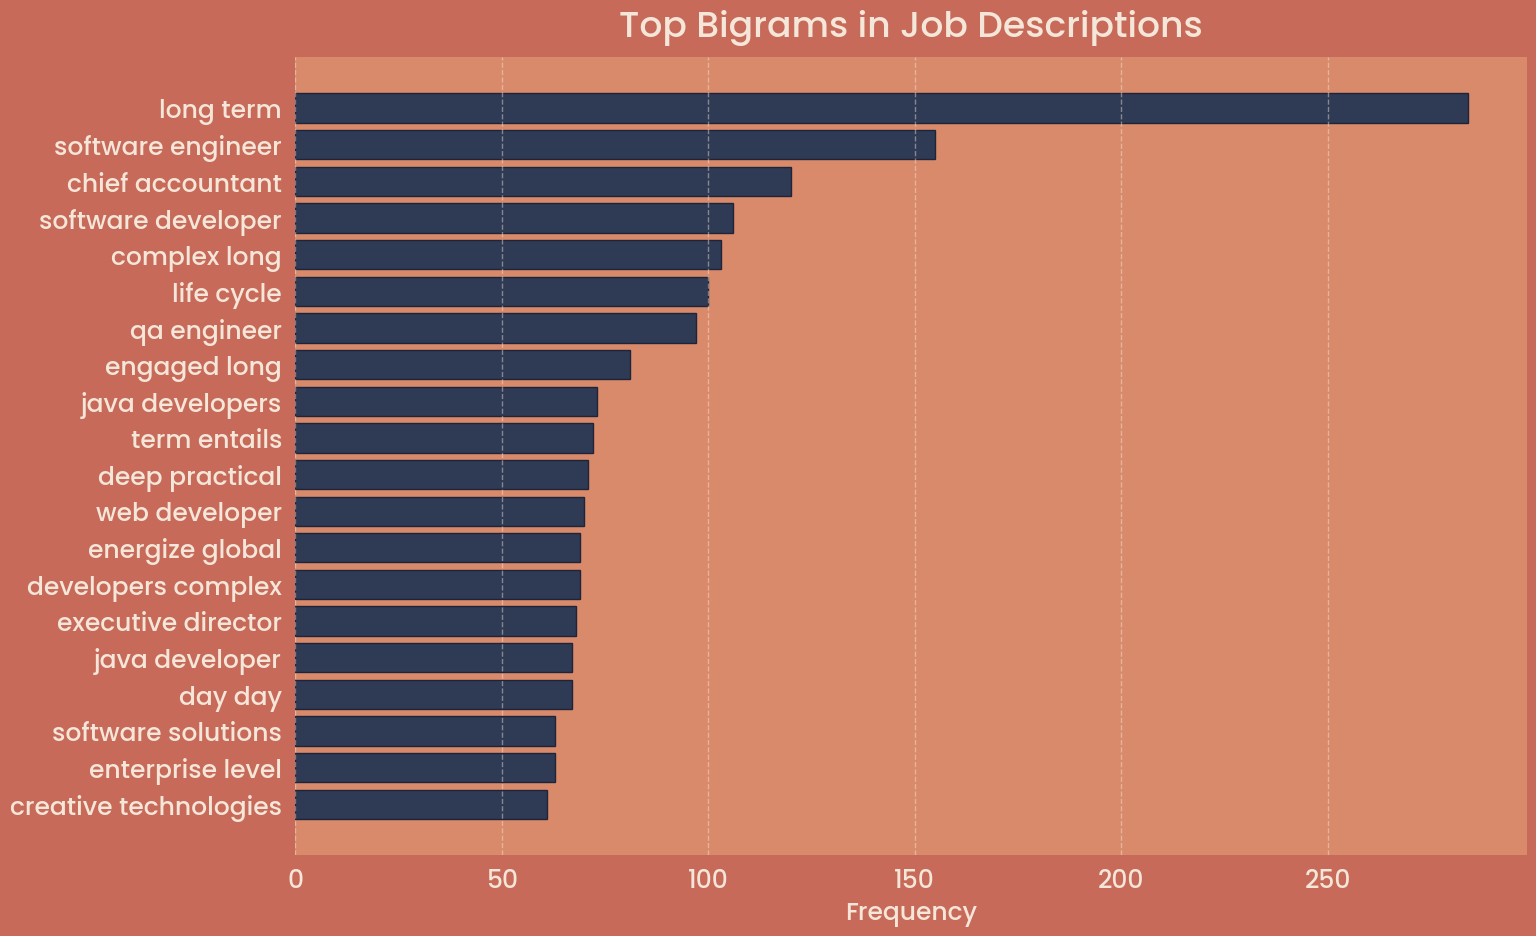

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# ------------------------ LOAD POPPINS ------------------------
font_path = "Poppins-Medium.ttf"   # your local file path
fm.fontManager.addfont(font_path)

plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.weight"] = "medium"


# ------------------------ BIGRAM FUNCTION ------------------------
def plot_top_ngrams(text_series, n=2, top_k=20, title="Top N-grams"):
    # Vectorizer that respects your custom stopwords
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        stop_words=list(stopwords.words("english")) + list(custom_stopwords),
        max_features=top_k
    )

    X = vectorizer.fit_transform(text_series)
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    
    # Reverse for clean barh ordering
    words, counts = zip(*sorted(zip(words, counts), key=lambda x: x[1]))
    
    # ---------------- Cadence Theme Colors ----------------
    bg_color       = "#C86A5A"   # terracotta background
    panel_color    = "#D98A6B"   # lighter terracotta
    text_color     = "#F4E6D8"   # warm cream
    bar_color      = "#2F3A55"   # soft navy
    grid_color     = "#F4E6D880" # semi-transparent cream
    
    # ---------------- Plot ----------------
    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(panel_color)

    ax.barh(words, counts, color=bar_color, edgecolor="#1E2538")

    # Text styling
    ax.set_title(title, fontsize=26, color=text_color, pad=15, fontweight="semibold")
    ax.set_xlabel("Frequency", fontsize=18, color=text_color)
    ax.tick_params(colors=text_color, labelsize=18, width=0, pad=6)

    # Gridlines
    ax.grid(axis="x", linestyle="--", linewidth=1.0, alpha=0.45, color=grid_color)

    # Remove borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout(pad=3)
    plt.show()


# ------------------------ CALLS ------------------------
plot_top_ngrams(resume_df['Resume_str'], n=2, top_k=20,
                title="Top Bigrams in Resumes")

plot_top_ngrams(job_posts_df['JobDescription'], n=2, top_k=20,
                title="Top Bigrams in Job Descriptions")


In [52]:
DOMAIN_KEYWORDS = {

    # ------------------------ TECH & IT ------------------------
    "Tech & IT": [
        "software engineer", "software developer", "backend", "frontend",
        "full stack", "api", "devops", "cloud", "aws", "azure", "gcp",
        "database", "sql", "python", "java", "javascript", "c++",
        "cybersecurity", "network", "system administration", "data science",
        "machine learning", "ai", "artificial intelligence", "automation",
        "docker", "kubernetes", "linux", "debugging", "testing"
    ],

    # ------------------------ FINANCE & ACCOUNTING ------------------------
    "Finance & Accounting": [
        "finance", "financial analyst", "accounting", "audit",
        "bookkeeping", "taxation", "ledger", "reconciliation",
        "accounts payable", "accounts receivable", "invoice",
        "budgeting", "forecasting", "balance sheet", "profit and loss",
        "cost analysis", "valuation", "treasury", "capital markets",
        "investment analysis", "economics"
    ],

    # ------------------------ BUSINESS & SALES ------------------------
    "Business & Sales": [
        "business development", "sales", "b2b", "b2c",
        "client acquisition", "crm", "pipeline management",
        "lead generation", "negotiation", "quota", "revenue growth",
        "upselling", "cross selling", "account executive",
        "partnerships", "closing deals"
    ],

    # ------------------------ LAW & ADVOCACY ------------------------
    "Law & Advocacy": [
        "legal", "attorney", "paralegal", "litigation",
        "contract law", "corporate law", "legal research",
        "compliance", "court filing", "case management",
        "intellectual property"
    ],

    # ------------------------ HEALTHCARE ------------------------
    "Healthcare": [
        "patient care", "nurse", "clinical", "medical assistant",
        "healthcare", "treatment", "therapy", "rehabilitation",
        "physician", "medication", "public health", "diagnosis"
    ],

    # ------------------------ HR & OPERATIONS ------------------------
    "HR & Operations": [
        "human resources", "hr", "recruitment", "recruiter",
        "talent acquisition", "payroll", "onboarding",
        "employee relations", "benefits administration",
        "performance review", "training development",
        "workforce planning", "operations management",
        "logistics", "inventory management", "vendor management"
    ],

    # ------------------------ CREATIVE & DESIGN ------------------------
    "Creative & Design": [
        "graphic design", "illustrator", "photoshop",
        "digital media", "branding", "ui design", "ux design",
        "content creation", "copywriting", "animation",
        "video editing", "social media", "creative direction"
    ],

    # ------------------------ EDUCATION ------------------------
    "Education": [
        "teacher", "professor", "lecturer", "curriculum development",
        "lesson planning", "student engagement", "tutoring",
        "instruction", "classroom management"
    ],

    # ------------------------ MANUFACTURING & CONSTRUCTION ------------------------
    "Manufacturing & Construction": [
        "construction", "blueprint", "mechanical", "electrical",
        "civil engineering", "safety compliance",
        "production line", "machinery", "quality assurance"
    ],

    # ------------------------ AGRICULTURE & ENVIRONMENT ------------------------
    "Agriculture & Environment": [
        "agriculture", "farming", "crop", "sustainability",
        "ecology", "forestry", "environmental management",
        "conservation", "water resources"
    ],

    # ------------------------ HOSPITALITY & FOOD ------------------------
    "Hospitality & Food": [
        "chef", "menu planning", "hospitality", "catering",
        "food safety", "sanitation", "guest relations",
        "restaurant operations"
    ],

    # ------------------------ OTHER SERVICES ------------------------
    "Other Services": [
        "customer service", "client service", "call center",
        "retail", "merchandising", "aviation", "pilot",
        "flight attendant", "bpo"
    ]
}


In [53]:
def count_keywords_in_series(text_series, domain_keywords):
    """Counts all domain keywords in a pandas Series of text efficiently."""
    
    # Lowercase and fill missing
    text_series = text_series.fillna("").str.lower()
    
    domain_counts = {domain: 0 for domain in domain_keywords}
    keyword_counts = Counter()

    for domain, keywords in domain_keywords.items():
        for kw in keywords:
            kw_lower = kw.lower()
            
            # Full-word or full-phrase match
            pattern = rf'\b{re.escape(kw_lower)}\b'
            
            count = text_series.str.count(pattern, flags=re.IGNORECASE).sum()

            if count > 0:
                domain_counts[domain] += count
                keyword_counts[(domain, kw)] += count

    return domain_counts, keyword_counts


In [55]:
resume_domain_counts, resume_kw_counts = count_keywords_in_series(
    resume_df['Resume_str'], 
    DOMAIN_KEYWORDS
)

job_domain_counts, job_kw_counts = count_keywords_in_series(
    job_posts_df['job_text'], 
    DOMAIN_KEYWORDS
)


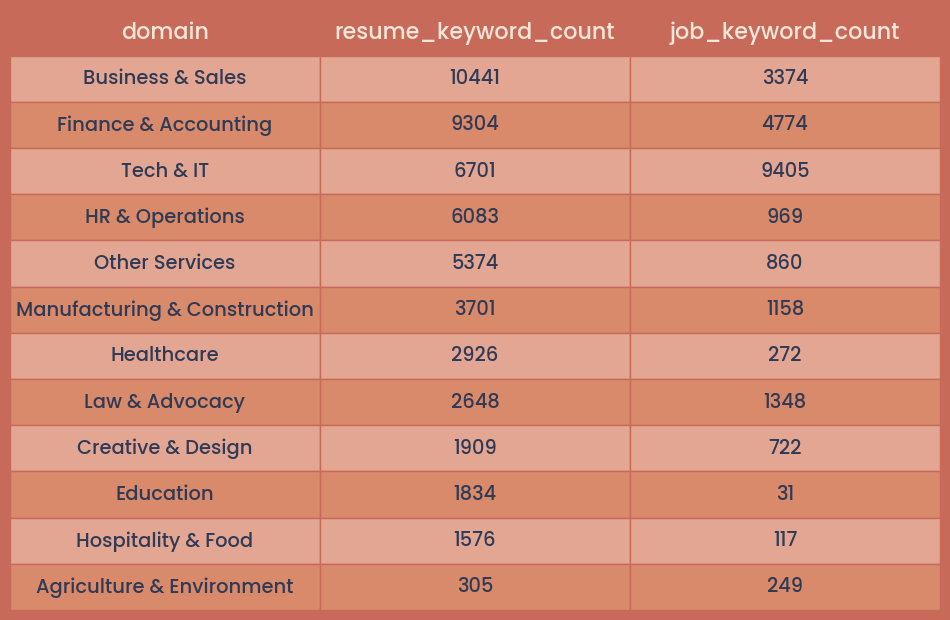

In [63]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Load Poppins
fm.fontManager.addfont("Poppins-Medium.ttf")
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.weight"] = "medium"

def plot_domain_table(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Theme colors
    header_color = "#C86A5A"      # terracotta
    cell_color   = "#D98A6B"      # lighter terracotta
    alt_cell     = "#E3A693"      # alternate row
    text_color   = "#2F3A55"      # navy text
    header_text  = "#F4E6D8"      # cream text
    
    ax.axis("off")

    # Build cell colors matrix
    cell_colors = []
    for i in range(len(df)):
        row_color = alt_cell if i % 2 == 0 else cell_color
        cell_colors.append([row_color] * len(df.columns))

    # Add table
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellColours=cell_colors,
        colColours=[header_color] * len(df.columns),
        cellLoc="center",
        colLoc="center",
        loc="center"
    )
    
    # Style cells
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    # Cell border + padding
    for key, cell in table.get_celld().items():
        row, col = key

        # Header row
        if row == 0:
            cell.set_text_props(color=header_text, fontsize=16, fontweight="semibold")
            cell.set_edgecolor("#C86A5A")
            cell.set_height(0.1)
        else:
            cell.set_text_props(color=text_color)
            cell.set_edgecolor("#C86A5A")
            cell.set_height(0.1)
    
    fig.patch.set_facecolor("#C86A5A")  # background to match slides
    plt.show()


# ---- Call it ----
plot_domain_table(domain_summary)


In [57]:
domain_summary

,domain,resume_keyword_count,job_keyword_count
2,Business & Sales,10441,3374
1,Finance & Accounting,9304,4774
0,Tech & IT,6701,9405
5,HR & Operations,6083,969
11,Other Services,5374,860
8,Manufacturing & Construction,3701,1158
4,Healthcare,2926,272
3,Law & Advocacy,2648,1348
6,Creative & Design,1909,722
7,Education,1834,31


In [54]:
# Show top 10 keywords by count
print("=== Resume Keyword Counts (Top 30) ===")
display(resume_kw_df.sort_values('resume_count', ascending=False).head(30))

print("=== Job Keyword Counts (Top 30) ===")
display(job_kw_df.sort_values('job_count', ascending=False).head(30))



=== Resume Keyword Counts (Top 30) ===


NameError: name 'resume_kw_df' is not defined

In [ ]:

print("=== Domain-Level Keyword Summary ===")
print(domain_summary, "\n")

print("=== Sample Keyword-Level Breakdown (Top 10) ===")
print(resume_kw_df.sort_values('resume_count', ascending=False))

In [ ]:
kw_compare = pd.merge(
    resume_kw_df, job_kw_df,
    on='(domain, keyword)', how='outer'
).fillna(0)

kw_compare['difference'] = kw_compare['resume_count'] - kw_compare['job_count']

# Show top 20 overrepresented in resumes
kw_compare.sort_values('difference', ascending=False).head(20)
